In [80]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
import seaborn as sns
import pandas as pd
import warnings
import scipy
from dsn.util.systems import Linear2D
from dsn.util.plot_util import plot_opt, assess_constraints, dsn_pairplots
from dsn.util.dsn_util import get_savedir
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
# filename info
basedir = '/Users/sbittner/Documents/dsn/dsn/';

latent_dynamics = None;
TIF_flow_type = 'PlanarFlow';
elem_mult_flow = True;
arch_dict = {'D':4, \
             'latent_dynamics':latent_dynamics, \
             'elem_mult_flow':elem_mult_flow, \
             'TIF_flow_type':TIF_flow_type, \
             'repeats':nlayers};

fixed_params = {'tau':1.0}

omega = 2;
mu = np.array([0.0, 2*np.pi*omega]);
Sigma = np.array([1.0, 1.0]);
behavior = {'type':'oscillation', 'means':mu, 'variances':Sigma};

system = Linear2D(fixed_params, behavior);
print(system.name)

nlayers = 10;
lr_order = -3
c_init = -5;
sigma_init = 1.0;
dir_str = 'test'

num_rs = 1
start_rs = 0;

fnames = [];
legendstrs = [];
for rs in range(start_rs, start_rs+num_rs):
    savedir = basedir + get_savedir(system, arch_dict, sigma_init, lr_order, \
                                    c_init, rs, dir_str)
    print(savedir)
    fname = savedir + 'opt_info.npz';
    fnames.append(fname);
    legendstr = 'rs=%d' % rs;
    legendstrs.append(legendstr);
    
    if (rs==start_rs):
        npzfile = np.load(fnames[0]);
        mu = npzfile['mu'];
        check_rate = npzfile['check_rate'];
        last_ind = npzfile['it']//check_rate;
        nits = npzfile['costs'].shape[0];
        k_max = npzfile['T_xs'].shape[0]-1;
        iterations = np.arange(0, check_rate*nits, check_rate);
    

Linear2D
/Users/sbittner/Documents/dsn/dsn/models/test/Linear2D_A_oscillation_flow=M_10P_sigma=1.00_lr_order=-3_c=-5_rs=0/


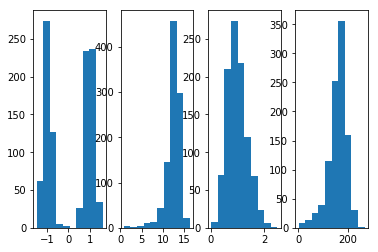

In [82]:
plt.figure()
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.hist(T_xs[1,:,i])
plt.show()

No handles with labels found to put in legend.


[[[1.08049332e-008 2.82432080e-082 4.88907043e-002 4.51113143e-135]
  [8.12260696e-001 5.46213289e-002 2.73624527e-001 5.90965705e-002]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+0

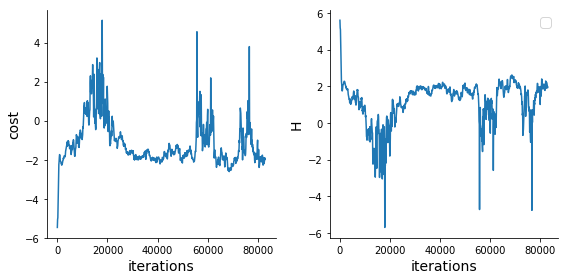

No handles with labels found to put in legend.


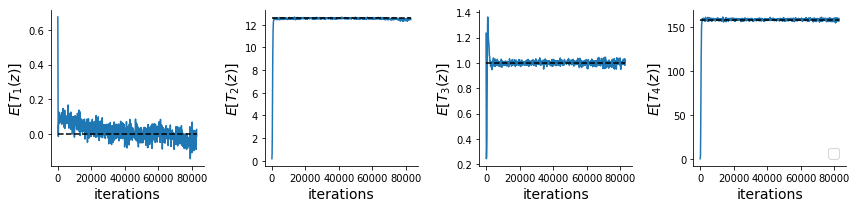

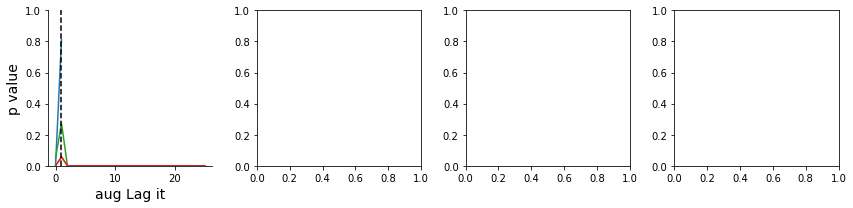

In [83]:
plot_opt(fnames, [''], plotR2=False);

[[[1.08049332e-008 2.82432080e-082 4.88907043e-002 4.51113143e-135]
  [8.12260696e-001 5.46213289e-002 2.73624527e-001 5.90965705e-002]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [            nan 0.00000000e+000 0.00000000e+0

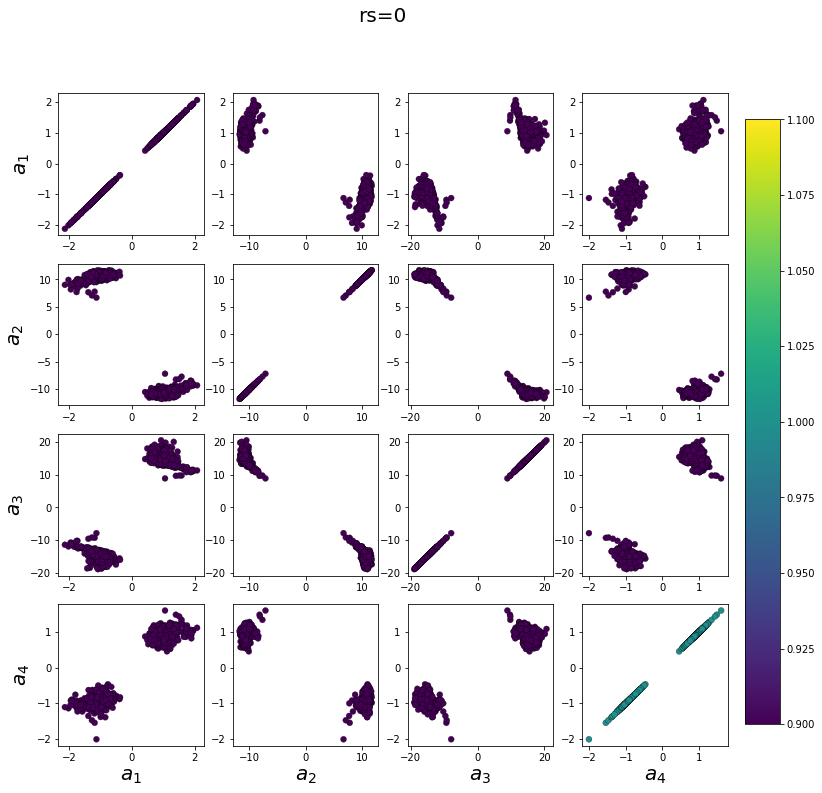

In [84]:
n_fnames = len(fnames);
alpha = 0.05;
p_values, AL_final_its = assess_constraints(fnames, alpha, k_max, system.num_suff_stats);
labels = [r'$a_1$', r'$a_2$', r'$a_3$', r'$a_4$']
dsn_pairplots(fnames, 'Zs', system, system.D, 'identity', 'log_q_phi', \
             legendstrs, AL_final_its, fontsize=20);

In [ ]:
dsn_pairplots(fnames, 'T_xs', system, system.D, 'identity', 'log_q_phi', \
             legendstrs, AL_final_its, fontsize=20);

In [49]:
special_plot = True
if (special_plot):
    it_converge = AL_final_its[0]*50000;
    fontsize = 14;
    Hs = npzfile['Hs'];
    fig = plt.figure();
    ax = fig.add_subplot(111);
    plt.plot(iterations[:last_ind], Hs[:last_ind]);
    plt.plot([it_converge, it_converge], [np.min(Hs), np.max(Hs)], 'k--');
    plt.xlabel('iterations', fontsize=fontsize);
    plt.ylabel(r'$H(q_\phi)$', fontsize=fontsize);
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show();

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

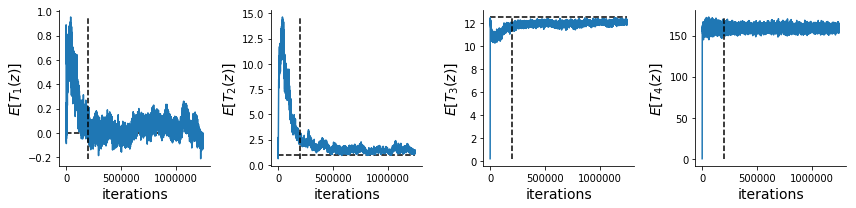

In [24]:
if (special_plot):
    it_converge = AL_final_its[0]*50000;
    mean_T_phis = npzfile['mean_T_phis'];
    n_suff_stats = mean_T_phis.shape[1];
    n_cols = 4;
    n_rows = int(np.ceil(n_suff_stats/n_cols));
    figsize = (n_cols*3, n_rows*3);
    fig2 = plt.figure(figsize=figsize);
    for i in range(n_suff_stats):
        ax = plt.subplot(n_rows,n_cols,i+1);
        plt.plot([iterations[0], iterations[last_ind]], [mu[i], mu[i]], 'k--');
        plt.plot(iterations[:last_ind], mean_T_phis[:last_ind,i]);
        plt.plot([it_converge, it_converge], [np.min(mean_T_phis[:,i]), np.max(mean_T_phis[:,i])], 'k--');
        plt.ylabel(r"$E[T_%d(z)]$" % (i+1), fontsize=fontsize);
        if (i > n_suff_stats - n_cols - 1):
            plt.xlabel('iterations', fontsize=fontsize);
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    plt.tight_layout();
    plt.show();